# An Microscope Image Auto-Focus Method based on Colorful-Gradient (simulation)

### Package import

In [19]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import cv2
import numpy as np
import pandas as pd
import shutil
import math
import operator
import pywt
import matplotlib.pyplot as plt
from operator import add, sub
from sklearn import preprocessing
from imutils import paths

### Function define

In [2]:
def image_colorfulness(image):
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    return stdRoot + (0.3 * meanRoot)

In [3]:
def image_laplacian(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm

In [4]:
def image_sharpness(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gy, gx = np.gradient(image)
    gnorm = np.sqrt(gx**2 + gy**2)
    return np.average(gnorm)

In [5]:
def list_minmaxscaler(target_value_list, scaled_range = (0,10)):
    target_value_list = np.array(target_value_list)
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=scaled_range)
    target_value_list = min_max_scaler.fit_transform(target_value_list.reshape(-1,1))
    target_value_list = target_value_list.reshape(1,-1)[0]
    return target_value_list

In [6]:
def image_cast(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(img)
    h,w,_ = img.shape
    da = a_channel.sum()/(h*w)-128
    db = b_channel.sum()/(h*w)-128
    histA = [0]*256
    histB = [0]*256
    for i in range(h):
        for j in range(w):
            ta = a_channel[i][j]
            tb = b_channel[i][j]
            histA[ta] += 1
            histB[tb] += 1
    msqA = 0
    msqB = 0
    for y in range(256):
        msqA += float(abs(y-128-da))*histA[y]/(w*h)
        msqB += float(abs(y - 128 - db)) * histB[y] / (w * h)
    result = math.sqrt(da*da+db*db)/math.sqrt(msqA*msqA+msqB*msqB)
    return result

In [7]:
def wavelet(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.float32(image)
    image /= 225
    coeffs = pywt.wavedec2(image, 'haar', level = 1)
    cA, (cH, cV, cD) = coeffs
    cA = np.absolute(cA)
    cA = np.absolute(cA)
    cA = np.absolute(cA)
    temp = np.array(list(map(add, cH, cV)))
    var_of_wavelet = np.var(cH) + np.var(cV) + np.var(cD)
    sum_of_wavelet = np.sum(cH) + np.sum(cH) + np.sum(cD)
    return sum_of_wavelet, var_of_wavelet

In [8]:
def DCT_based(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = np.float32(image)
    img_dct = cv2.dct(img)
    dc = np.square(img_dct[0][0])
    img_dct[0][0] = 0
    ac_reduced = np.square(img_dct[0][1]) + np.square(img_dct[1][0]) + np.square(img_dct[1][1]) +np.square(img_dct[0][2]) + np.square(img_dct[2][0])  
    img_dct = np.square(img_dct)
    ac = np.sum(img_dct)
    return ac/dc, ac_reduced/dc

### Sharpness value compare
#### Gradient-based v.s. Laplacian-based

Image directory path:  ./images/sharpness_compare


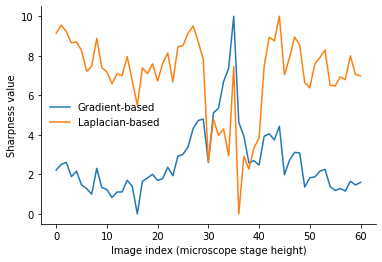

In [14]:
 if __name__ == "__main__":
    image_path = './images/sharpness_compare'
    Sharpness_list = []    
    Laplacian_list = []
    image_file_sorted = sorted(paths.list_images(image_path))
    count = 0
    for index, image_file in enumerate(image_file_sorted):
        print("Current progress: ", count, "/", len(image_file_sorted),end="\r")
        count += 1
        # Read image from directory with opencv
        image = cv2.imread(image_file)
        # Sharpness calculation
        sharpness = image_sharpness(image)
        laplacian = image_laplacian(image)
        # Store both values into list.
        Sharpness_list.append(sharpness)
        Laplacian_list.append(laplacian)
    # Min max scaler for Sharpness and Colorfulness list
    print("Image directory path: ", image_path)
    Sharpness_list = list_minmaxscaler(Sharpness_list)
    Laplacian_list = list_minmaxscaler(Laplacian_list)
    x = np.arange(0,len(Sharpness_list))

    ax = plt.subplot()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.plot(x, Sharpness_list, label = "Gradient-based")
    ax.plot(x, Laplacian_list, label = "Laplacian-based")

    plt.legend(frameon=False)
    plt.xlabel("Image index (microscope stage height)")
    plt.ylabel("Sharpness value")
    plt.show()

### Colorfulness value compare
#### With Colorfulness value v.s. Without colorfulness value

Image directory path:  ./images/colorfulness_compare


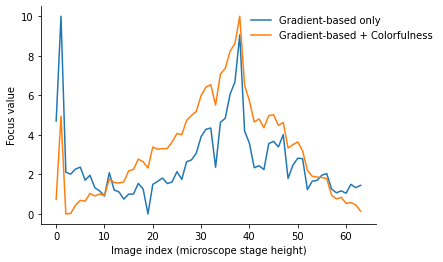

In [15]:
 if __name__ == "__main__":
    image_path = './images/colorfulness_compare'
    Colorfulness_list = []
    Sharpness_list = []
    image_file_sorted = sorted(paths.list_images(image_path))
    count = 0
    for index, image_file in enumerate(image_file_sorted):
        print("Current progress: ", count, "/", len(image_file_sorted),end="\r")
        count += 1
        # Read image from directory with opencv
        image = cv2.imread(image_file)
        # Sharpness calculation
        sharpness = image_sharpness(image)
        # Colorfulness calculation
        colorfulness = image_colorfulness(image)
        # Store both values into list.
        Colorfulness_list.append(colorfulness)
        Sharpness_list.append(sharpness)
    print("Image directory path: ", image_path)
    # Min max scaler for Sharpness and Colorfulness list
    Sharpness_list = list_minmaxscaler(Sharpness_list)
    Colorfulness_list = list_minmaxscaler(Colorfulness_list)
    x = np.arange(0,len(Sharpness_list))
    Summary_list = np.array(list(map(add, Colorfulness_list, Sharpness_list)))
    Summary_list = list_minmaxscaler(Summary_list)
    ax = plt.subplot()

    ax.plot(x, Sharpness_list, label = "Gradient-based only")
    ax.plot(x, Summary_list, label = "Gradient-based + Colorfulness")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
    plt.legend(bbox_to_anchor = (0.6, 1) , fancybox=True, framealpha=0.5, frameon=False)
    plt.xlabel("Image index (microscope stage height)")
    plt.ylabel("Focus value")
    plt.show()

### Overall Benchmark Example
#### Colorful-gradient operators v.s. 6 conventional operators

Image directory path:  ./images/benchmark


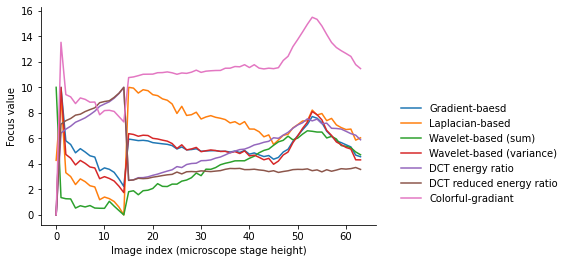

In [17]:
 if __name__ == "__main__":
    image_path = './images/benchmark'
    Colorfulness_list = []
    Color_cast_list = []
    Sharpness_list = []
    Laplacian_list = []
    Wavelet_sum_list = []
    Wavelet_var_list = []
    DCT_ratio_list = []
    DCT_reduced_ratio_list = []
    image_file_sorted = sorted(paths.list_images(image_path))
    count = 0
    for index, image_file in enumerate(image_file_sorted):
        print("Current progress: ", count, "/", len(image_file_sorted),end="\r")
        count += 1
        # Read image from directory with opencv
        image = cv2.imread(image_file)  
        # DCT ratio
        dct_ratio, dct_reduced_ratio = DCT_based(image)
        wavelet_sum, wavelet_var = wavelet(image)    
        # Sharpness calculation
        sharpness = image_sharpness(image)
        laplacian = image_laplacian(image)
        # Colorfulness calculation
        colorfulness = image_colorfulness(image)
        color_cast = image_cast(image)
        # Store both values into list.
        Colorfulness_list.append(colorfulness)
        Color_cast_list.append(color_cast)
        Sharpness_list.append(sharpness)
        Laplacian_list.append(laplacian)
        Wavelet_sum_list.append(wavelet_sum)
        Wavelet_var_list.append(wavelet_var)
        DCT_ratio_list.append(dct_ratio)
        DCT_reduced_ratio_list.append(dct_reduced_ratio)
        
    print("Image directory path: ", image_path)
    # Min max scaler for Sharpness and Colorfulness list
    Sharpness_list = list_minmaxscaler(Sharpness_list)
    Laplacian_list = list_minmaxscaler(Laplacian_list)
    Colorfulness_list = list_minmaxscaler(Colorfulness_list)
    Color_cast_list = list_minmaxscaler(Color_cast_list, scaled_range = (1,10))
    Color_cast_list = 1/Color_cast_list
    Wavelet_sum_list = list_minmaxscaler(Wavelet_sum_list)
    Wavelet_var_list = list_minmaxscaler(Wavelet_var_list)
    DCT_ratio_list = list_minmaxscaler(DCT_ratio_list)
    DCT_reduced_ratio_list = list_minmaxscaler(DCT_reduced_ratio_list)
    x = np.arange(0,len(Sharpness_list))
        
    Color_score_list = list(map(operator.mul, Color_cast_list, Colorfulness_list))
    Summary_list = np.array(list(map(add, Color_score_list, Sharpness_list)))
    
    ax = plt.subplot()
    ax.plot(x, Sharpness_list, label = "Gradient-baesd")
    ax.plot(x, Laplacian_list, label = "Laplacian-based")
    ax.plot(x, Wavelet_sum_list, label = "Wavelet-based (sum)")
    ax.plot(x, Wavelet_var_list, label = "Wavelet-based (variance)")
    ax.plot(x, DCT_ratio_list, label = "DCT energy ratio")
    ax.plot(x, DCT_reduced_ratio_list, label = "DCT reduced energy ratio")
    ax.plot(x, Summary_list, label = "Colorful-gradiant")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.legend(bbox_to_anchor = (1.05, 0.6) , fancybox=True, framealpha=0.5, frameon=False)
    plt.xlabel("Image index (microscope stage height)")
    plt.ylabel("Focus value")
    plt.show()
    